In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
!pip install tensorflow --upgrade
# !pip install tensorflow-gpu --upgrade
!pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import os
import cv2
import numpy as np
from imutils import paths
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.applications import ResNet50
from keras.layers import Input
from keras.layers.pooling import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
datapath='Dataset_02'


In [5]:
Sports_Labels = set(['boxing','swimming','table_tennis'])
print("Images is being loaded.....")

Images is being loaded.....


In [6]:
pathToImages = list(paths.list_images(datapath))
data =[]
labels = []
for images in pathToImages:
    label = images.split(os.path.sep)[-2]
    if label not in Sports_Labels:
        continue
    image = cv2.imread(images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    data.append(image)
    labels.append(label)

In [7]:
import pickle
path = 'Sports_Image_Classification_1/data'
with open(path, "wb") as fp:
  pickle.dump(data, fp)
path = 'Sports_Image_Classification_1/lables'
with open(path, "wb") as fp:
  pickle.dump(labels, fp)

In [8]:
import pickle
path = 'Sports_Image_Classification_1/data'
with open(path, "rb") as fp:
  data = pickle.load(fp)
path = 'Sports_Image_Classification_1/lables'
with open(path, "rb") as fp:
  labels = pickle.load(fp)

In [9]:
# Convert to numpy array and apply Hot Encoder
from numpy import array
from sklearn.preprocessing import LabelBinarizer
data = np.array(data)
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [44]:
#Train Test and Split
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
test_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 32
EPOCH = 25

In [12]:
#Augmentation
from keras.preprocessing.image import ImageDataGenerator
trainingAugmentation = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
validationAugmentation = ImageDataGenerator()
mean = np.array([123.68,116.979,103.939],dtype="float32")
trainingAugmentation.mean=mean
validationAugmentation.mean=mean

In [13]:
from keras.applications import ResNet50
from keras.layers import Input
from keras.layers.pooling import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model

In [14]:
baseModel = ResNet50(weights="imagenet",include_top=False,input_tensor=None,input_shape=(224,224,3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_),activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for basemodelLayers in baseModel.layers:
    basemodelLayers.trainable = False


In [15]:
from keras.optimizers import SGD 
opt = SGD(learning_rate=0.00001, momentum=0.9, decay=1e-2/EPOCH)

In [16]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
BATCH_SIZE = 64
history = model.fit(trainingAugmentation.flow(x_train,y_train,batch_size=BATCH_SIZE),
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    validation_data=(x_test,y_test),
                    validation_steps=len(x_test) // BATCH_SIZE,
                    epochs=EPOCH,
                    verbose=1)

Epoch 1/25
24/24 [==============================] - 82s 3s/step - loss: 1.5657 - accuracy: 0.3694 - val_loss: 1.0343 - val_accuracy: 0.5163
Epoch 2/25
24/24 [==============================] - 77s 3s/step - loss: 1.3708 - accuracy: 0.4246 - val_loss: 0.9455 - val_accuracy: 0.5545
Epoch 3/25
24/24 [==============================] - 78s 3s/step - loss: 1.3843 - accuracy: 0.4299 - val_loss: 0.8760 - val_accuracy: 0.5946
Epoch 4/25
24/24 [==============================] - 73s 3s/step - loss: 1.3089 - accuracy: 0.4405 - val_loss: 0.8203 - val_accuracy: 0.6386
Epoch 5/25
24/24 [==============================] - 75s 3s/step - loss: 1.1852 - accuracy: 0.4957 - val_loss: 0.7721 - val_accuracy: 0.6673
Epoch 6/25
24/24 [==============================] - 81s 3s/step - loss: 1.1295 - accuracy: 0.5256 - val_loss: 0.7321 - val_accuracy: 0.6960
Epoch 7/25
24/24 [==============================] - 82s 3s/step - loss: 1.0722 - accuracy: 0.5262 - val_loss: 0.6938 - val_accuracy: 0.7208
Epoch 8/25
24/24 [==

In [18]:
pred_cv = model.predict(x_test)

17/17 [==============================] - 19s 1s/step


In [45]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test_val=np.argmax(y_test, axis=1)

cv_report = classification_report(y_test_val, y_pred,target_names = Sports_Labels)

print(cv_report)

17/17 [==============================] - 20s 1s/step
              precision    recall  f1-score   support

table_tennis       0.83      0.94      0.88       176
    swimming       0.94      0.90      0.92       171
      boxing       0.86      0.77      0.81       176

    accuracy                           0.87       523
   macro avg       0.88      0.87      0.87       523
weighted avg       0.87      0.87      0.87       523



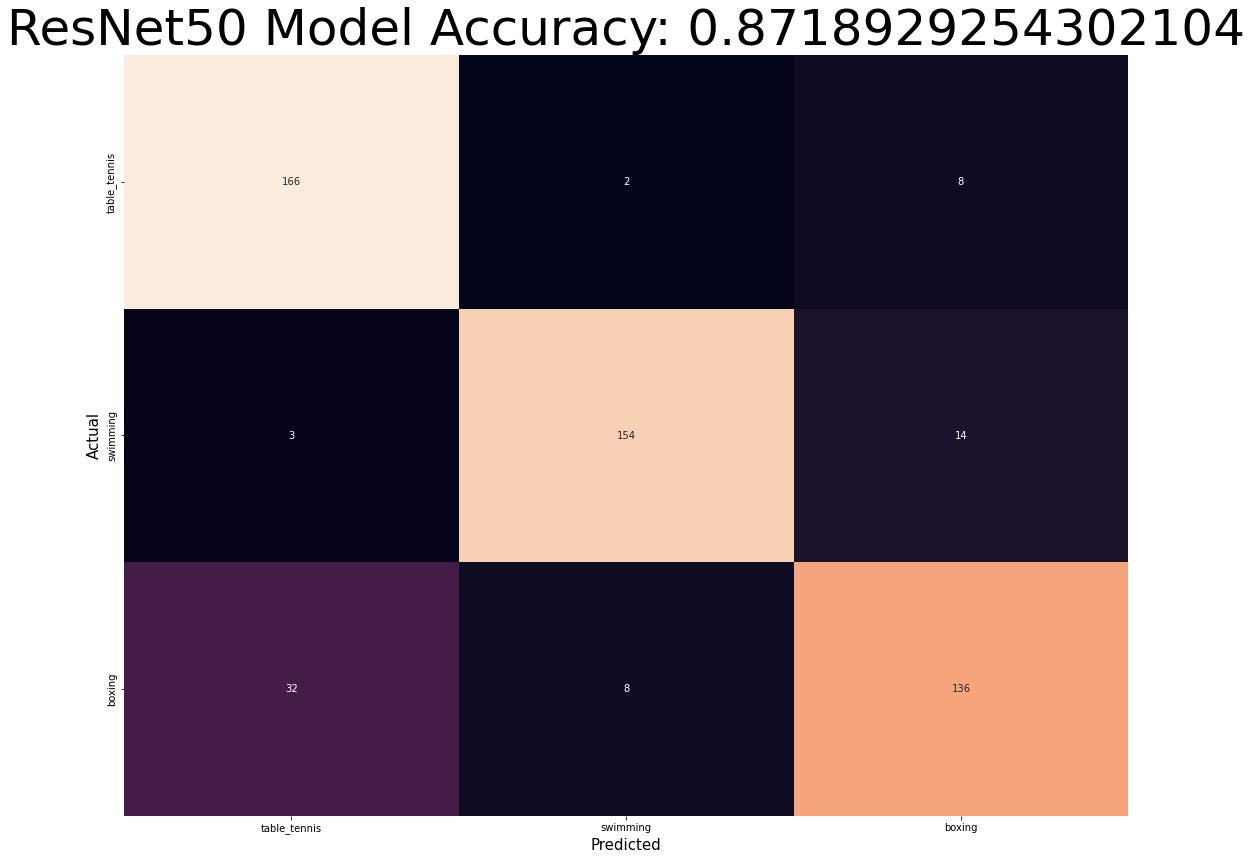

In [23]:
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),pred_cv.argmax(axis=-1))
#print("CNN Accuracy:",ann_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),pred_cv.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cbar=False,xticklabels=Sports_Labels,yticklabels=Sports_Labels)
plt.title("ResNet50 Model Accuracy: {}".format(cnn_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

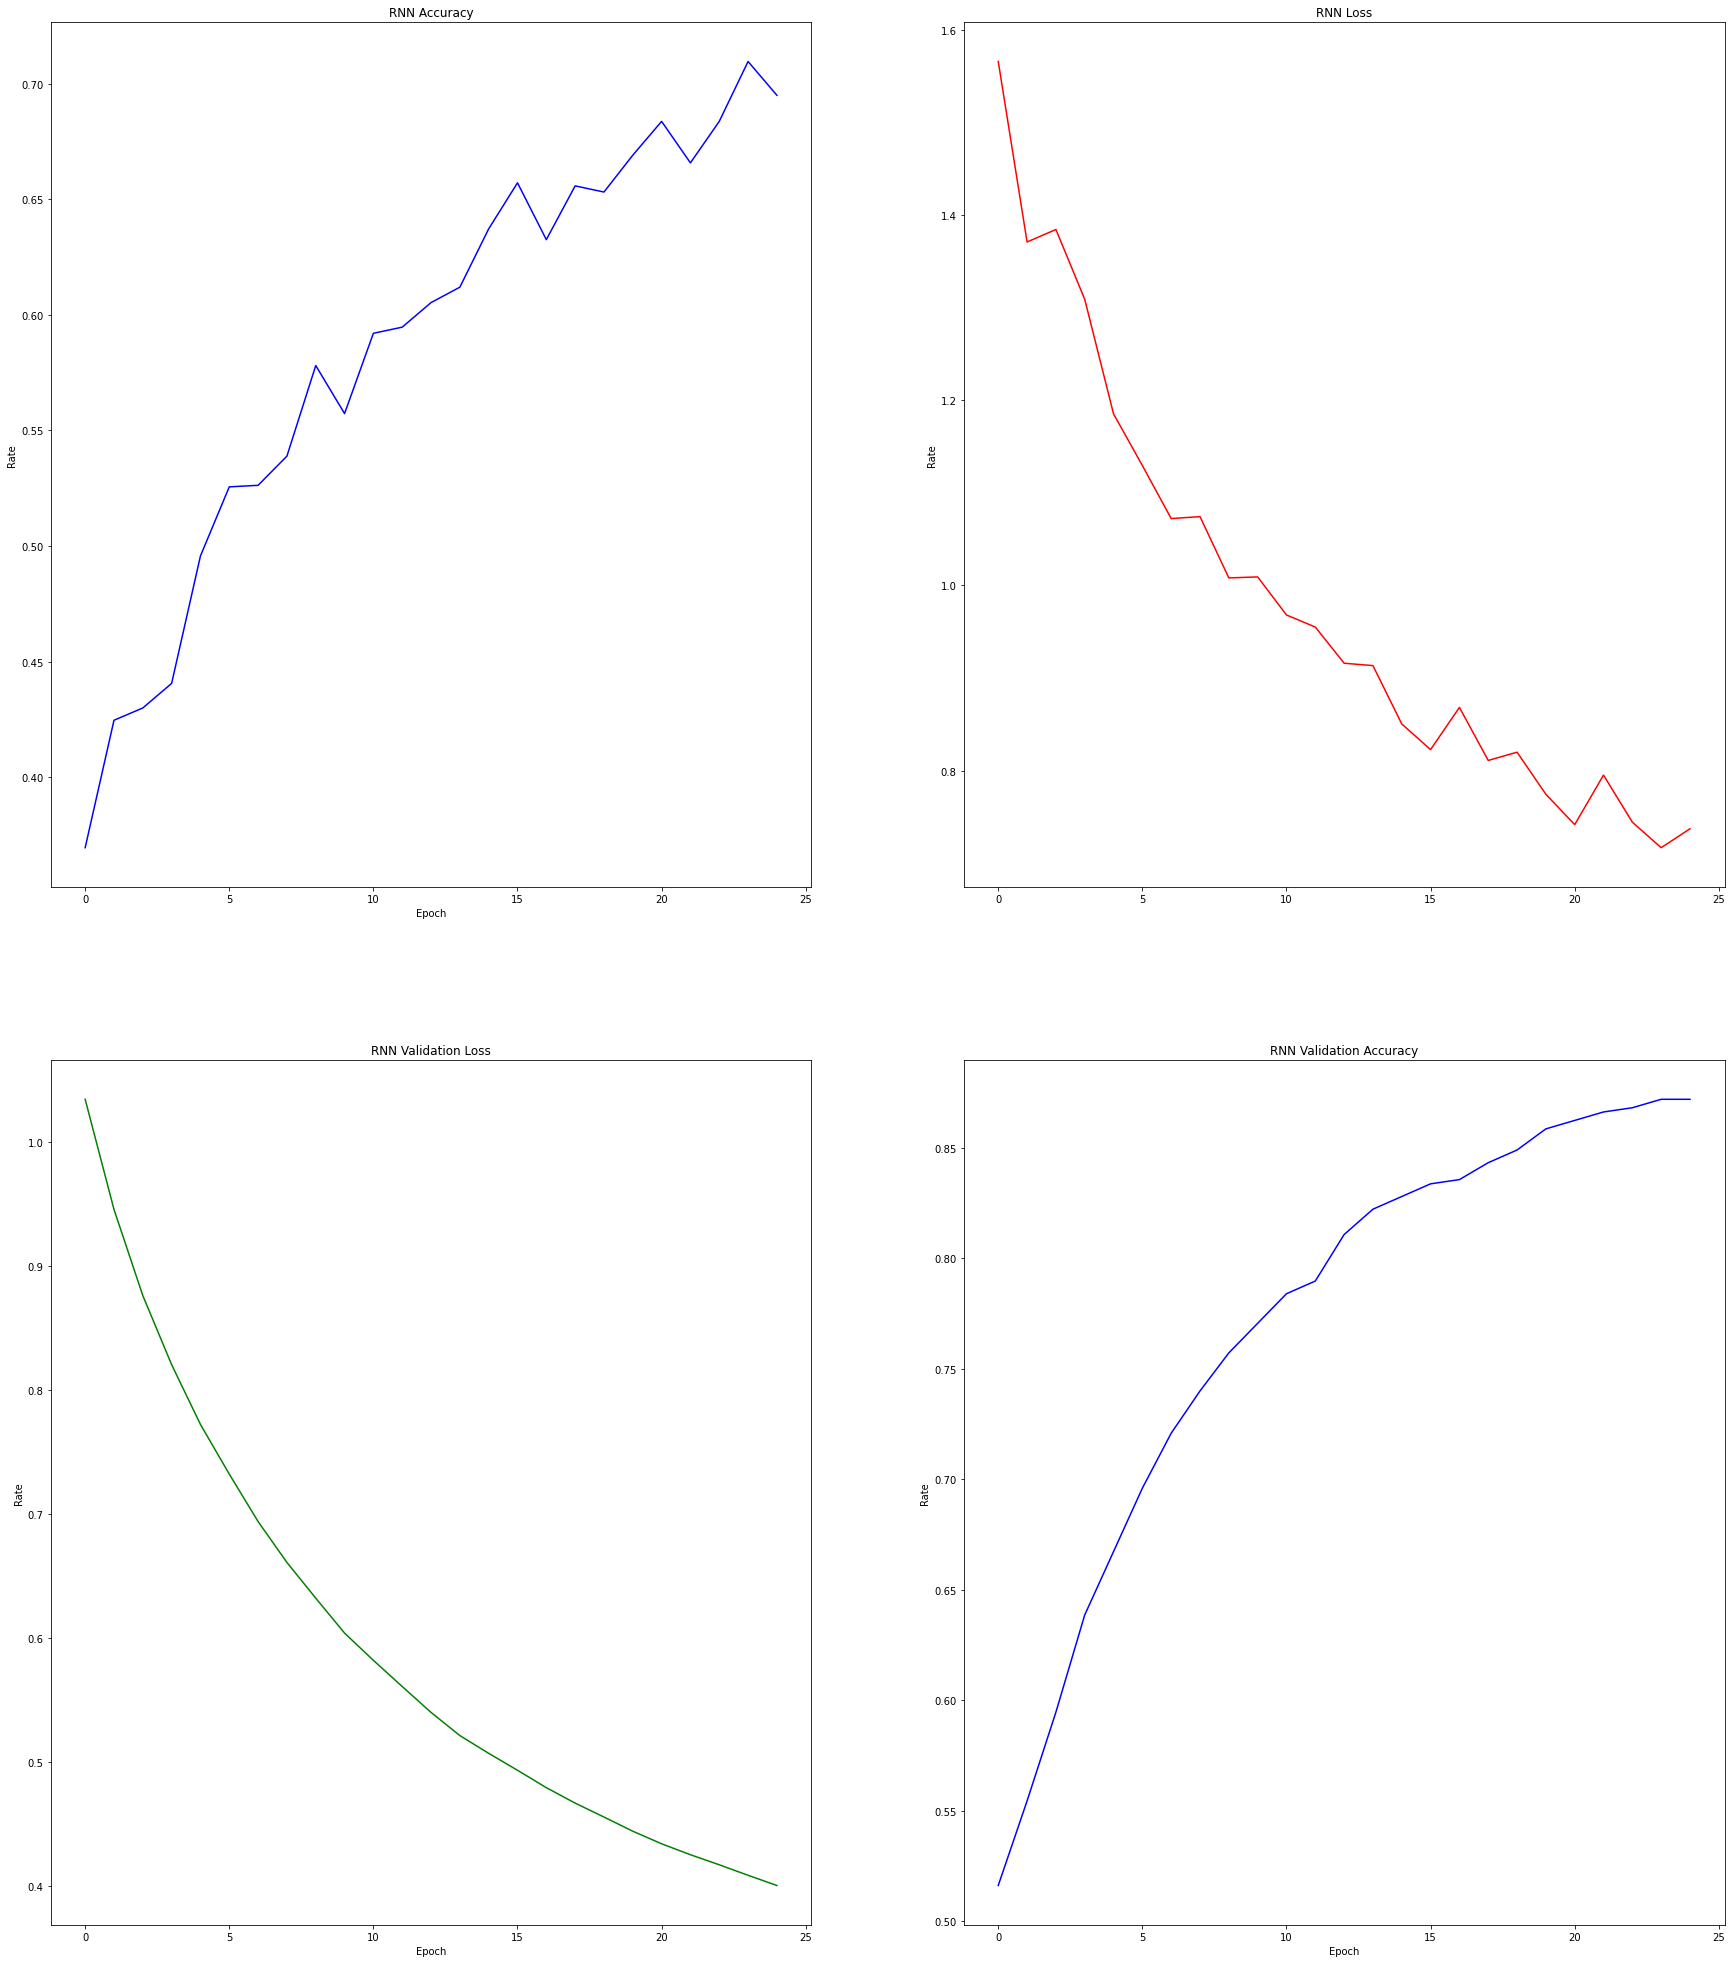

In [56]:
fig3, axe1 = plt.subplots(nrows=2, ncols=2, figsize=(30,35))
axe1[0][0].plot(history.history["accuracy"],label="accuracy",color="blue")
axe1[0][1].plot(history.history["loss"],label="loss",color="red")
axe1[1][0].plot(history.history["val_loss"],label="val_loss",color="green")
axe1[1][1].plot(history.history["val_accuracy"],label="val_accuracy",color="blue")
axe1[0][0].title.set_text("RNN Accuracy")
axe1[0][1].title.set_text("RNN Loss")
axe1[1][0].title.set_text("RNN Validation Loss")
axe1[1][1].title.set_text("RNN Validation Accuracy")
axe1[0][0].set_xlabel("Epoch")
axe1[1][0].set_xlabel("Epoch")
axe1[1][1].set_xlabel("Epoch")
axe1[1][1].set_xlabel("Epoch")
axe1[0][0].set_ylabel("Rate")
axe1[0][1].set_ylabel("Rate")
axe1[1][0].set_ylabel("Rate")
axe1[1][1].set_ylabel("Rate")
plt.show()